# **Feature Engineering**

## Objectives

* Engineer new features from the existing dataset to improve model performance.
## Inputs

* output/datasets/collection/insurance.csv

## Outputs

* Processed train and test datasets with new features added. 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/medical-insurance-prediction/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/medical-insurance-prediction'

# Load Dataset


In [4]:
import pandas as pd
df_raw_path = "outputs/datasets/cleaned/insurance_cleaned.csv"
df = pd.read_csv(df_raw_path)
df.head(10)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


---

# Feature Engineering

We will enconde and create new features based on the existing ones to enhance the model's predictive power.

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

def prepare_features_for_modeling(df):
    """
    Performs feature engineering, encoding, and scaling for the insurance dataset.
    
    Parameters:
    - df (pd.DataFrame): Raw insurance dataset
    
    Returns:
    - df_processed (pd.DataFrame): Processed DataFrame ready for ML modeling
    """
    df = df.copy()

    # Feature Engineering
    df['age_squared'] = df['age'] ** 2
    df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 50, 65],
                             labels=['Young', 'Adult', 'Middle-aged', 'Senior'])

    df['bmi_class'] = pd.cut(df['bmi'], bins=[0, 18.5, 24.9, 29.9, float('inf')],
                             labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    df['is_overweight'] = (df['bmi'] >= 25).astype(int)

    df['smoker_flag'] = (df['smoker'] == 'yes').astype(int)
    df['smoker_bmi_risk'] = df['smoker_flag'] * df['bmi']
    df['age_bmi_risk'] = df['age'] * df['bmi'] / 100

    # Risk Score
    def calculate_risk_score(row):
        score = 0
        if row['smoker'] == 'yes':
            score += 50
        if row['bmi'] >= 30:
            score += 30
        elif row['bmi'] >= 25:
            score += 15
        if row['age'] >= 50:
            score += 25
        elif row['age'] >= 35:
            score += 15
        score += row['children'] * 5
        return score

    df['risk_score'] = df.apply(calculate_risk_score, axis=1)

    # Encoding and Scaling
    le = LabelEncoder()
    df['sex_encoded'] = le.fit_transform(df['sex'])
    df['smoker_encoded'] = le.fit_transform(df['smoker'])

    df = pd.get_dummies(df, columns=['region', 'age_group', 'bmi_class'], drop_first=True)

    scaler = StandardScaler()
    numeric_features = ['age', 'bmi', 'age_squared', 'smoker_bmi_risk', 'age_bmi_risk']
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

    # Final Features
    keep_columns = [
        'age', 'age_squared', 'sex_encoded', 'bmi', 'children',
        'smoker_encoded', 'is_overweight', 'smoker_bmi_risk',
        'age_bmi_risk', 'risk_score'
    ]
    encoded_columns = [col for col in df.columns if col.startswith('region_') or
                       col.startswith('age_group_') or col.startswith('bmi_class_')]

    df_processed = df[keep_columns + encoded_columns + ['charges']]

    return df_processed

In [6]:
df_processed = prepare_features_for_modeling(df)

# View ready-to-model features
print(df_processed.head())

        age  age_squared  sex_encoded       bmi  children  smoker_encoded  \
0 -1.438764    -1.220462            0 -0.453320         0               1   
1 -1.509965    -1.253341            1  0.509621         1               0   
2 -0.797954    -0.844579            1  0.383307         3               0   
3 -0.441948    -0.573551            1 -1.305531         0               0   
4 -0.513149    -0.631311            1 -0.292556         0               0   

   is_overweight  smoker_bmi_risk  age_bmi_risk  risk_score  region_northwest  \
0              1         1.699463     -1.304476          65             False   
1              1        -0.494516     -1.155629          35             False   
2              1        -0.494516     -0.550476          45             False   
3              0        -0.494516     -0.884952           0              True   
4              1        -0.494516     -0.550170          15              True   

   region_southeast  region_southwest  age_group_A

**Encoding categorical variables:**
* Convert categorical variables into numerical format using techniques like one-hot encoding or label encoding.
* Drop original categorical columns after encoding to avoid redundancy.
  
**Numerical transformations:**
* Apply scaling to numerical features to better perform in linear models.

---

# Find correlation between new features

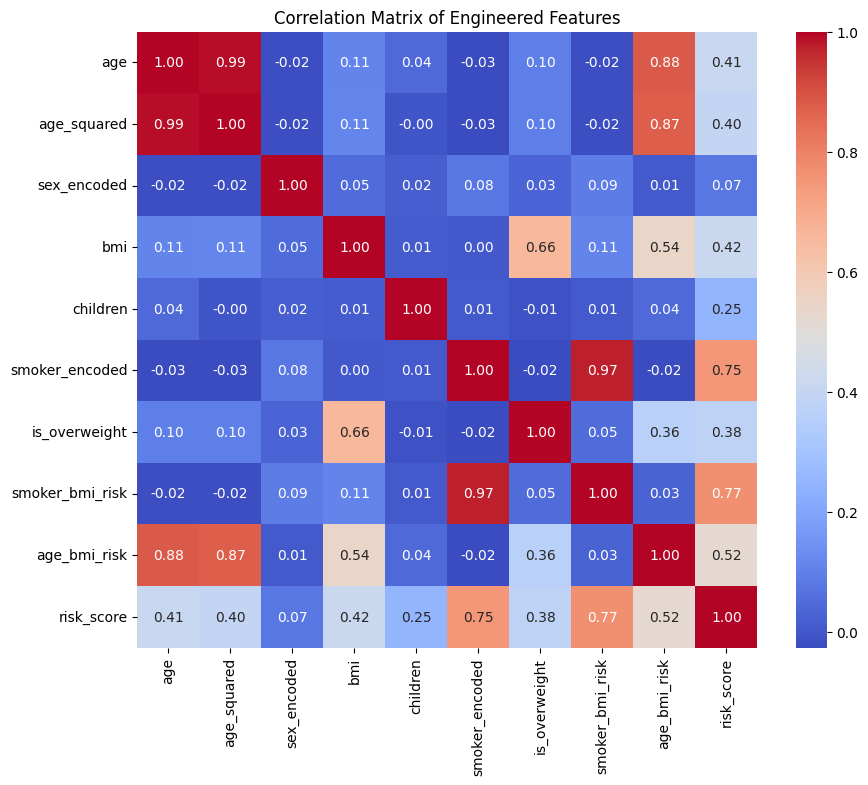

In [7]:
import seaborn as sns

import matplotlib.pyplot as plt

# Compute correlation matrix for new features (excluding 'charges')
new_features = [
    'age', 'age_squared', 'sex_encoded', 'bmi', 'children',
    'smoker_encoded', 'is_overweight', 'smoker_bmi_risk',
    'age_bmi_risk', 'risk_score'
]
corr_matrix = df_processed[new_features].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Engineered Features')
plt.show()

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [8]:
import os
try:
  os.makedirs(name='outputs/datasets/engineered', exist_ok=True)
except Exception as e:
  print(e)

df_processed.to_csv('outputs/datasets/engineered/insurance_engineered.csv', index=False)


# Conclusions and Next Steps

## Conclusions
* We have successfully engineered new features from the existing dataset.

# Next Steps
* We can now proceed to model training and evaluation using the enhanced dataset.